In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv, merge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, clear_output, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [39]:
class litho_optim:
    
    def __init__(self, exposure_data, inspec_data):
        
        self.exposure_data = read_csv(exposure_data, header=0)
        self.inspec_data = read_csv(inspec_data, header=0)
    
    def clean_data(self):
        """this funtion is to clean data and merged them into the dataset of self.data_array """

        # drop rows with missing values, printing the row counts before and after
        self.exposure_data.dropna(inplace=True)

        # drop rows with missing values, printing the row counts before and after
        self.inspec_data.dropna(inplace=True)
    
        # merge data into a single DataFrame
        self.merged_data = merge(self.exposure_data, self.inspec_data, how='inner', on=['Lot', 'Wafer', 'FieldX', 'FieldY'], sort=False)
        self.data_array = self.merged_data.to_numpy()

    def get_xy(self):
        
        """this funtion is to extract the data to get Focus[nm] and Dose [mJ], return plot as a figure"""
        
        self.X = self.data_array[:,9:11].astype(float) # 9 is focus and 11 is exposure dose
        self.Y = self.data_array[:,12].astype(int) #12 is 'label' data (where '0' represents no defect and '1' represents a defect)
        
        mask = self.Y.astype(bool)
        a = 20*np.ones(mask.shape)
        a_good = np.ma.masked_where(mask, a)
        a_bad = np.ma.masked_where(np.logical_not(mask), a)
        fig = plt.figure(figsize=(5,5), dpi=100)
        axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
        axes.scatter(self.X[:,0], self.X[:,1], s=a_good, color='C0', label='Good chips',edgecolor='k',linewidths=0.5)
        axes.scatter(self.X[:,0], self.X[:,1], s=a_bad, color='C3', label='Die chips',edgecolor='k',linewidths=0.5)
        axes.set_xlabel('Focus [nm]')
        axes.set_ylabel('Dose [mJ]')
        axes.set_title('Raw Data');
        axes.legend(loc=4);

    def data_preparation(self, Standardize=True):
        
        """this funtion is a preparation of data for the model training"""
        
        # Split the data into training and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=0.2, random_state = 42)
        
        if (Standardize):
            # Create a 'StandardScaler' instance and adjust the normalization transforms to the training data
            self.scaler = StandardScaler()
            self.scaler.fit(self.X)

            # Now apply the transformations to the the training and test sets
            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)
            self.X_stdize = self.scaler.transform(self.X)
    
    def train_mpl_model(self):
        
        """this funtion is to train the multilayer perceptron model

        Return:
            object: multilayer perceptron model, which is a trained by self.X_train, self.y_train
        """
            
        # Define a multi-layer perceptron classifier with three hidden layers, each with 40 neurons
        self.mlp_model = MLPClassifier(hidden_layer_sizes=(40,40,40), random_state = 42)

        # Fit the classifier to the training data
        self.mlp_model.fit(self.X_train, self.y_train);
        
        return self.mlp_model
    
    def train_gpc_model(self):
        
        """this funtion is to train the GaussianProcessClassifier model

        Return:
            object: GaussianProcessClassifier model, which is a trained by self.X_train, self.y_train
        """
        
        kernel = 1.0 * RBF(1.0)
        self.gpc_model = GaussianProcessClassifier(kernel=kernel, random_state = 42)

        # Fit the classifier to the training data
        self.gpc_model.fit(self.X_train, self.y_train);
        
        return self.gpc_model
    
    def train_svc_model(self):
        
        """this funtion is to train the Support Vector Machines classifier model

        Return:
            object: Support Vector Machines classifier model, which is a trained by self.X_train, self.y_train
        """
            
        self.svc_model = SVC(gamma=2, C=1, random_state=42)

        # Fit the classifier to the training data
        self.svc_model.fit(self.X_train, self.y_train);
        
        return self.svc_model
    
    def get_meshgrid(self):
        
        """this funtion create the meshgrid with in the range of X: Focus[nm] and Y:Dose [mJ]"""
        
        # Create a mesh grid for the plot
        x_min, x_max = np.min(self.X_stdize[:,0]) - 0.5, np.max(self.X_stdize[:,0]) + 0.5
        y_min, y_max = np.min(self.X_stdize[:,1]) - 0.5, np.max(self.X_stdize[:,1]) + 0.5
        
        self.xx_vec = np.arange(x_min, x_max, 0.1)
        self.yy_vec = np.arange(y_min, y_max, 0.1)
        
        self.xx, self.yy = np.meshgrid(self.xx_vec, self.yy_vec)
        self.meshgrid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
    def predict_defect(self, model, X_input):
    
        """this funtion take 2 argument and return the result

        Args:
            model(Object): the model
            X_input(array): an array of model input with dimensions of (bacth, 2)

        Return:
            array: predictions
        """
    
        return model.predict(X_input)
    
    def decision_boundary(self, model, model_name ='Prediction'):
        
        """this funtion create decision_boundary on the plane of X: Focus[nm] and Y:Dose [mJ], return plot as a figure
            
        Args:
            model(Object): the model
            model_name(string): plot title of the decision_boundary
        
        """
        
        #To see the decision boundary, we first build the grid within the range of prediction
        self.get_meshgrid()
        pred = self.predict_defect(model, self.meshgrid)
        z_meshgrid = pred.reshape(self.xx.shape)

        self.meshgrid_invers = self.scaler.inverse_transform(self.meshgrid)
        
        xx = self.meshgrid_invers[:,0].reshape(self.xx.shape)
        yy = self.meshgrid_invers[:,1].reshape(self.xx.shape)
        
        #print(np.shape(self.meshgrid))
        #print(np.shape(z_meshgrid))
        #print(np.shape(self.meshgrid_invers))
        
        fig = plt.figure(figsize=(5,5), dpi=100)
        axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
        axes.contourf(xx, yy, z_meshgrid, cmap='RdYlBu_r', alpha=0.6)
        
        mask = self.Y.astype(bool)
        a = 20*np.ones(mask.shape)
        a_good = np.ma.masked_where(mask, a)
        a_bad = np.ma.masked_where(np.logical_not(mask), a)
        axes.scatter(self.X[:,0], self.X[:,1], s=a_good, color='C0', label='Good chips',edgecolor='k',linewidths=0.5)
        axes.scatter(self.X[:,0], self.X[:,1], s=a_bad, color='C3', label='Die chips',edgecolor='k',linewidths=0.5)
        axes.set_xlabel('Focus [nm]')
        axes.set_ylabel('Dose [mJ]')
        axes.set_title(model_name);
        axes.legend(loc=4);
    
    def get_confusion_matrix(self, model):
        
        """this funtion give classification_report for the specific model
            
        Args:
            model(Object): the model
   
        """
        
        predictions = self.predict_defect(model, self.X_test)
        print(confusion_matrix(self.y_test,predictions))
        print(classification_report(self.y_test,predictions))

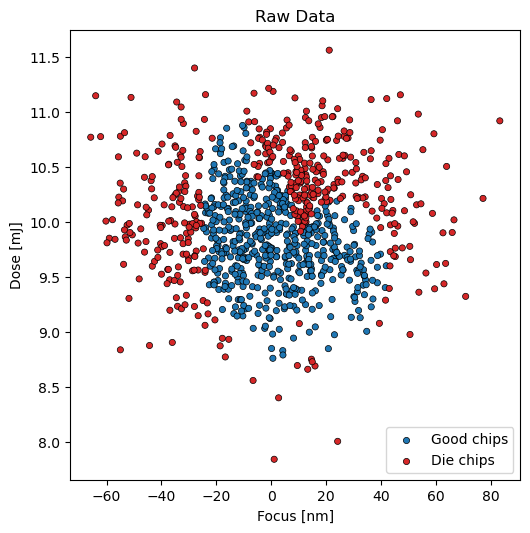

In [40]:
exposure_data = r'E:\Python_Projects_Git\2_SemiconManufacProcessYieldOptim\data\exposure_data.csv'
inspec_data = r'E:\Python_Projects_Git\2_SemiconManufacProcessYieldOptim\data\inspection_data.csv'

#main

A1 = litho_optim(exposure_data, inspec_data)
A1.clean_data()
A1.get_xy()
A1.data_preparation()

# MPL

C:\Users\kseon\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[[116   3]
 [  3  78]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       119
           1       0.96      0.96      0.96        81

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



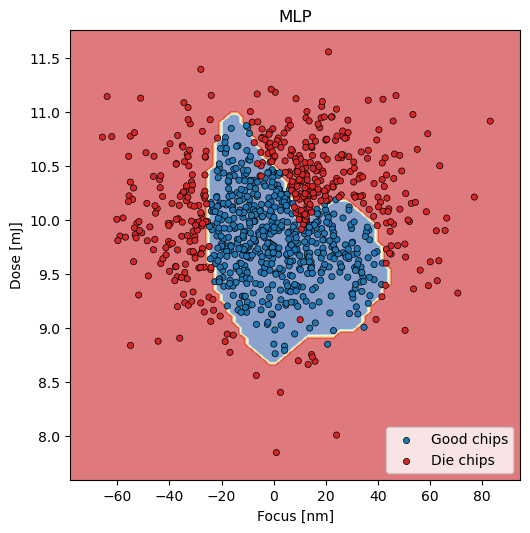

In [41]:
mlp_model = A1.train_mpl_model()
A1.decision_boundary(mlp_model, model_name ='MLP')
A1.get_confusion_matrix(mlp_model)

# Gaussian Process(GP)

[[117   2]
 [  3  78]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       119
           1       0.97      0.96      0.97        81

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



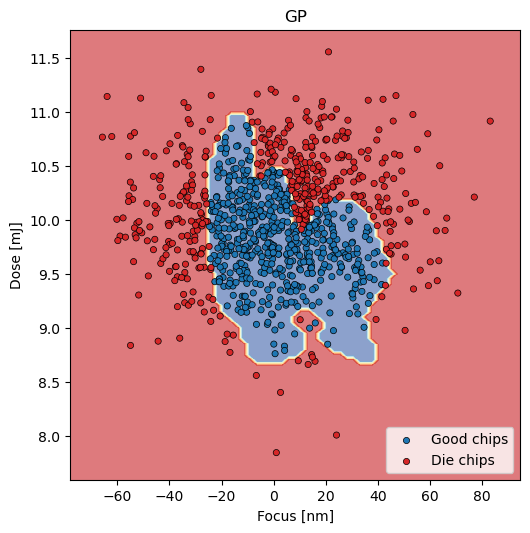

In [42]:
gpc_model = A1.train_gpc_model()
A1.decision_boundary(gpc_model, model_name ='GP')
A1.get_confusion_matrix(gpc_model)

# Supporting Vector Machine(SVM)

[[116   3]
 [  6  75]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       119
           1       0.96      0.93      0.94        81

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



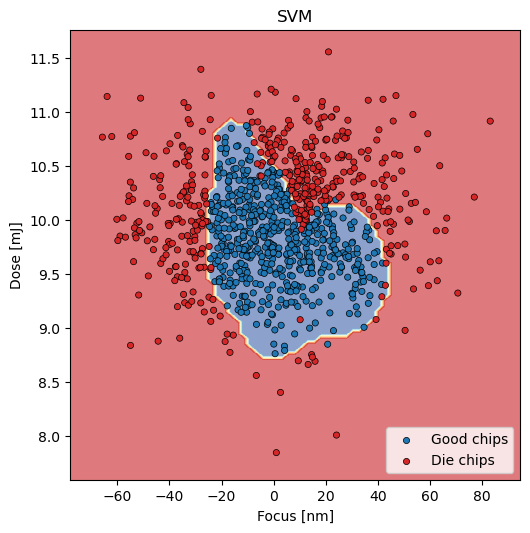

In [43]:
svc_model = A1.train_svc_model()
A1.decision_boundary(svc_model, model_name ='SVM')
A1.get_confusion_matrix(svc_model)